This notebook uses the following files from other notebooks:
- the selected sequence and charge pickle from the notebook "analyse the isotope intensity adjustment by peptide"
- requires extracted frames converted run databases using the script "open-path/notebooks/extract-rt-apex-frames.py"

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt

In [3]:
MAPPING_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/recalibrated-percolator-output/percolator-idx-mapping.csv"

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

#### select the sequence/charge of interest, and the runs to look at

In [17]:
selected_sequence = 'VGMGTCQGELCACR'
selected_sequence_charge = 2

In [18]:
selected_sequence_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/sequence-{}-charge-{}-df.pkl'.format(selected_sequence, selected_sequence_charge))

In [19]:
selected_sequence_df

,sequence,charge,file_idx,inferred,intensity,isotope_idx_not_in_saturation,isotope_intensities_l,monoisotopic_mz,rt_apex,scan_apex,...,batch,human,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence
9861,VGMGTCQGELCACR,2,11,0,156,0,"[(156.0, False, [(799.8285930434901, 548.0, 38...",799.830678,408.599333,558.000000,...,1to1,False,7.285402,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
14254,VGMGTCQGELCACR,2,16,0,3645,0,"[(3645.0, False, [(799.8285540374922, 528.0, 3...",799.830514,417.251846,536.941795,...,1to1,False,11.831703,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
5516,VGMGTCQGELCACR,2,6,0,275,0,"[(275.0, False, [(799.8285573989439, 548.0, 38...",799.830377,410.151899,538.892912,...,1to1,False,8.103288,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
13363,VGMGTCQGELCACR,2,15,0,314,0,"[(314.0, False, [(799.828590779191, 530.0, 388...",799.830385,410.431346,527.117600,...,1to1,False,8.294621,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
16053,VGMGTCQGELCACR,2,18,0,3992,0,"[(3992.0, False, [(799.8285938751997, 533.0, 3...",799.830675,417.199852,536.306847,...,1to1,False,11.962896,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
16941,VGMGTCQGELCACR,2,19,0,5008,0,"[(5008.0, False, [(799.8285783602244, 527.0, 3...",799.830914,415.295015,534.602056,...,1to1,False,12.290019,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
1097,VGMGTCQGELCACR,2,1,0,3872,0,"[(3872.0, False, [(799.8330421118716, 517.0, 3...",799.833042,415.350370,533.600592,...,1to1,False,11.918863,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
9011,VGMGTCQGELCACR,2,10,0,4211,0,"[(4211.0, False, [(799.833022934568, 526.0, 39...",799.833023,415.137313,533.130711,...,1to1,False,12.039947,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
1970,VGMGTCQGELCACR,2,2,0,4589,0,"[(4589.0, False, [(799.8285508703831, 527.0, 3...",799.830618,414.060928,535.722781,...,1to1,False,12.163964,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20
7281,VGMGTCQGELCACR,2,8,0,4567,0,"[(4567.0, False, [(799.8286040283056, 530.0, 3...",799.830726,415.324736,536.993477,...,1to1,False,12.157031,11.962916,1.792879,411.87259,2.917651,535.191377,6.049406,20


In [20]:
selected_sequence_df.columns

Index(['sequence', 'charge', 'file_idx', 'inferred', 'intensity',
       'isotope_idx_not_in_saturation', 'isotope_intensities_l',
       'monoisotopic_mz', 'rt_apex', 'scan_apex', 'classed_as', 'run_name',
       'batch', 'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence'],
      dtype='object')

In [22]:
# the runs of interest for comparison
run_name_A = '190719_Hela_Ecoli_1to1_01'
file_idx_A = file_idx_for_run(run_name_A)

run_name_B = '190719_Hela_Ecoli_1to1_02'
file_idx_B = file_idx_for_run(run_name_B)

#### compare the sequence in run A

In [23]:
# get the row for the selected run
sequence_in_file_A = selected_sequence_df[selected_sequence_df.file_idx == file_idx_A].iloc[0]

# convert the list of isotopes for thie sequence in this run into a DF
isotopes_A_df = pd.DataFrame(sequence_in_file_A.isotope_intensities_l, columns=['summed_intensity','saturated','isotope_points','isotope_apex_points','inferred_intensity','inferred'])

# extract the raw points of each isotope
frame_ids_A = set()
isotope_points_A_l = []
isotope_apex_points_A_l = []

for idx,isotope in isotopes_A_df.iterrows():
    points_l = isotope.isotope_points
    isotope_points_df = pd.DataFrame(points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])
    isotope_points_A_l.append(isotope_points_df)
    
    apex_points_l = isotope.isotope_apex_points
    isotope_apex_points_df = pd.DataFrame(apex_points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])
    isotope_apex_points_A_l.append(isotope_apex_points_df)
    frame_ids_A = frame_ids_A.union(isotope_apex_points_df.frame_id.astype(int).to_list())

# the frames to extract for the sequence's apex in RT
print("extract these frames from {}: {}".format(run_name_A, ' '.join([str(v) for v in frame_ids_A])))

extract these frames from 190719_Hela_Ecoli_1to1_01: 3849 3859 3854


#### compare the sequence in run B

In [25]:
# get the row for the selected run
sequence_in_file_B = selected_sequence_df[selected_sequence_df.file_idx == file_idx_B].iloc[0]

# convert the list of isotopes for thie sequence in this run into a DF
isotopes_B_df = pd.DataFrame(sequence_in_file_B.isotope_intensities_l, columns=['summed_intensity','saturated','isotope_points','isotope_apex_points','inferred_intensity','inferred'])

# extract the raw points of each isotope
frame_ids_B = set()
isotope_points_B_l = []
isotope_apex_points_B_l = []

for idx,isotope in isotopes_B_df.iterrows():
    points_l = isotope.isotope_points
    isotope_points_df = pd.DataFrame(points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])
    isotope_points_B_l.append(isotope_points_df)
    
    apex_points_l = isotope.isotope_apex_points
    isotope_apex_points_df = pd.DataFrame(apex_points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])
    isotope_apex_points_B_l.append(isotope_apex_points_df)
    frame_ids_B = frame_ids_B.union(isotope_apex_points_df.frame_id.astype(int).to_list())

# the frames to extract for the sequence's apex in RT
print("extract these frames from {}: {}".format(run_name_B, ' '.join([str(v) for v in frame_ids_B])))

extract these frames from 190719_Hela_Ecoli_1to1_02: 3945 3940 3925 3935


#### run this command to extract the frames at the RT apex
- python ./open-path/notebooks/extract-rt-apex-frames.py -en dwm-test -rn 190719_Hela_Ecoli_1to1_09 -fid 9654 9659 9664

and download the output files

In [26]:
frames_subset_A_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/frames-subsets/{}-frames-subset-df.pkl'.format(run_name_A))
scan_lower = sequence_in_file_A.scan_apex - (10 * sequence_in_file_A.experiment_scan_std_dev)
scan_upper = sequence_in_file_A.scan_apex + (10 * sequence_in_file_A.experiment_scan_std_dev)
mz_lower = sequence_in_file_A.monoisotopic_mz - 1
mz_upper = sequence_in_file_A.monoisotopic_mz + 7
frames_subset_A_df = frames_subset_A_df[(frames_subset_A_df.scan >= scan_lower) & (frames_subset_A_df.scan <= scan_upper) & (frames_subset_A_df.mz >= mz_lower) & (frames_subset_A_df.mz <= mz_upper) & (frames_subset_A_df.frame_id.isin(list(frame_ids_A)))]

frames_subset_B_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/frames-subsets/{}-frames-subset-df.pkl'.format(run_name_B))
scan_lower = sequence_in_file_B.scan_apex - (10 * sequence_in_file_B.experiment_scan_std_dev)
scan_upper = sequence_in_file_B.scan_apex + (10 * sequence_in_file_B.experiment_scan_std_dev)
mz_lower = sequence_in_file_B.monoisotopic_mz - 1
mz_upper = sequence_in_file_B.monoisotopic_mz + 7
frames_subset_B_df = frames_subset_B_df[(frames_subset_B_df.scan >= scan_lower) & (frames_subset_B_df.scan <= scan_upper) & (frames_subset_B_df.mz >= mz_lower) & (frames_subset_B_df.mz <= mz_upper) & (frames_subset_B_df.frame_id.isin(list(frame_ids_B)))]


#### plots for comparing the selected sequence in run A and run B

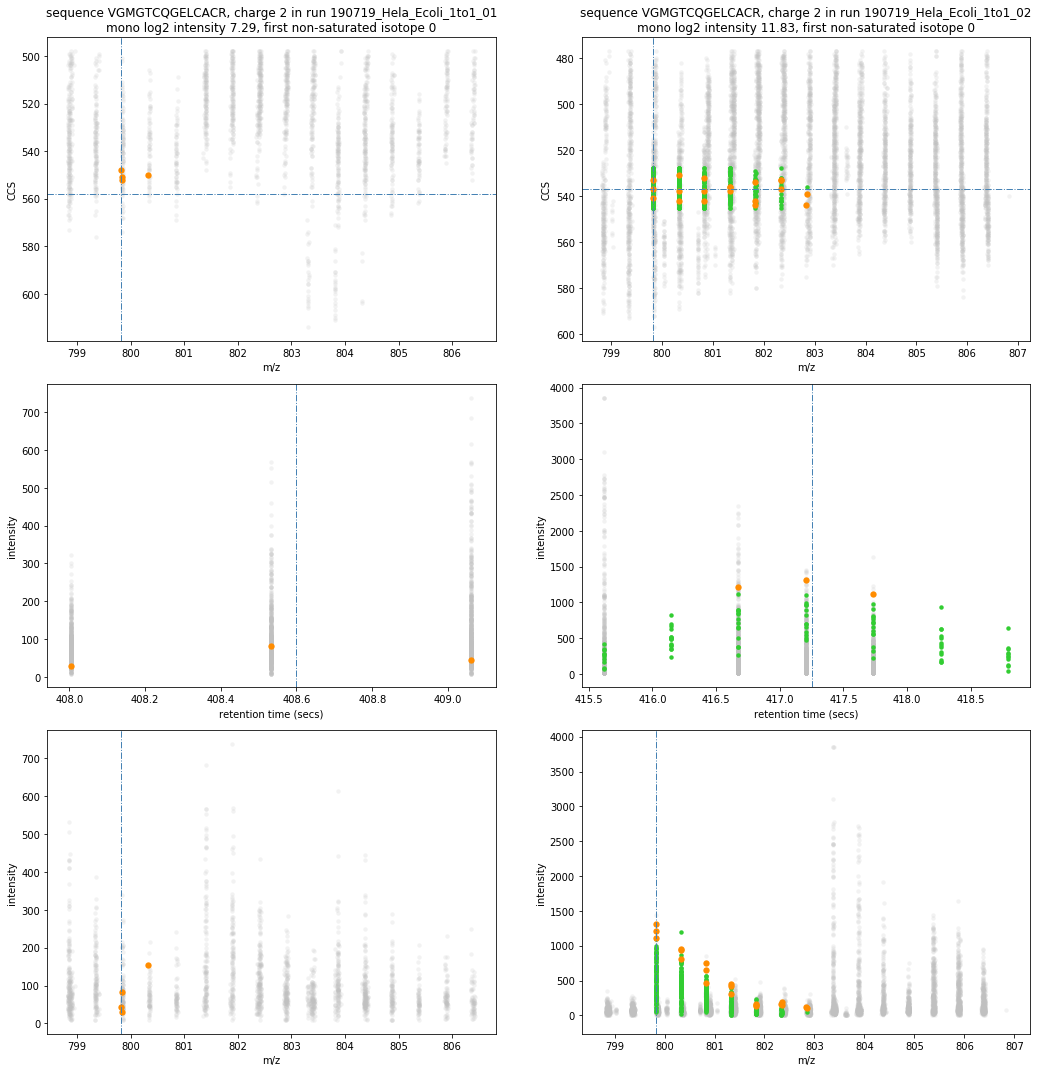

In [27]:
f, axarr = plt.subplots(nrows=3, ncols=2)

f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

########
# run A - mz vs scan
########
ax = axarr[0,0]  # row, column
ax.set_title('sequence {}, charge {} in run {}\nmono log2 intensity {}, first non-saturated isotope {}'.format(sequence_in_file_A.sequence, sequence_in_file_A.charge, sequence_in_file_A.run_name, round(sequence_in_file_A.log_intensity,2), sequence_in_file_A.isotope_idx_not_in_saturation))

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.mz, frames_subset_A_df.scan, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_A_l:
    ax.scatter(df.mz, df.scan, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_A_l:
    ax.scatter(df.mz, df.scan, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_A.monoisotopic_mz, color='steelblue', lw=1.0, ls='-.')
ax.axhline(sequence_in_file_A.scan_apex, color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('CCS')
ax.invert_yaxis()

########
# run A - RT vs intensity
########
ax = axarr[1,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.retention_time_secs, frames_subset_A_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
df = isotope_points_A_l[0]
ax.scatter(df.retention_time_secs, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
df = isotope_apex_points_A_l[0]
ax.scatter(df.retention_time_secs, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_A.rt_apex, color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('retention time (secs)')
ax.set_ylabel('intensity')

########
# run A - mz vs intensity
########
ax = axarr[2,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.mz, frames_subset_A_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_A_l:
    ax.scatter(df.mz, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_A_l:
    ax.scatter(df.mz, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_A.monoisotopic_mz, color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('intensity')






########
# run B - mz vs scan
########
ax = axarr[0,1]
ax.set_title('sequence {}, charge {} in run {}\nmono log2 intensity {}, first non-saturated isotope {}'.format(sequence_in_file_B.sequence, sequence_in_file_B.charge, sequence_in_file_B.run_name, round(sequence_in_file_B.log_intensity,2), sequence_in_file_B.isotope_idx_not_in_saturation))

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.mz, frames_subset_B_df.scan, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_B_l:
    ax.scatter(df.mz, df.scan, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_B_l:
    ax.scatter(df.mz, df.scan, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_B.monoisotopic_mz, color='steelblue', lw=1.0, ls='-.')
ax.axhline(sequence_in_file_B.scan_apex, color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('CCS')
ax.invert_yaxis()

########
# run B - RT vs intensity
########
ax = axarr[1,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.retention_time_secs, frames_subset_B_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
df = isotope_points_B_l[0]
ax.scatter(df.retention_time_secs, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
df = isotope_apex_points_B_l[0]
ax.scatter(df.retention_time_secs, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_B.rt_apex, color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('retention time (secs)')
ax.set_ylabel('intensity')

########
# run B - mz vs intensity
########
ax = axarr[2,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.mz, frames_subset_B_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_B_l:
    ax.scatter(df.mz, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_B_l:
    ax.scatter(df.mz, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_B.monoisotopic_mz, color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('intensity')

plt.tight_layout()
plt.show()